The database is composed by several CSV (Comma-Separated Values) files, each one with 8 columns, one column for each sensor, according to:

column 1 tachometer signal that allows to estimate rotation frequency;

columns 2 to 4 underhang bearing accelerometer (axial, radiale tangential direction);

columns 5 to 7 overhang bearing accelerometer (axial, radiale tangential direction);

column 8 microphone.

source: https://www02.smt.ufrj.br/~offshore/mfs/page_01.html

Nesse projeto eliminamos as colunas 1, 2, 3, 7 de cada arquivo csv. Restaram as leituras do tacômetro e do acelerômetro triaxial em 4, 5 e 6 (ax, rd and tan):

0 - Tachometer.
1 - Axial direct.
2 - radial direct.
3 - tangential direct.

According to the description of the columns there are not one two radial orthogonal accelerometers. Thus, it is not possible to observe the movement orbit of the rotating machine.

On the other hand, perhaps the tangential accelerometer is also moving radially, therefore orthogonal to the radial accelerometer.

Soft-DTW é uma função de perda diferenciável usada em análise de séries temporais, baseada no Dynamic Time Warping (DTW). Permite comparar séries de tamanhos variáveis, é robusta a deslocamentos e dilatações no tempo, e pode ser usada em aprendizado de máquina para tarefas como média, clustering e previsão.


In [ ]:
%pip install tensorflow==2.12.0
%pip install keras==2.12.0

In [ ]:
%pip install soft-dtw

In [1]:
pip show soft-dtw

Name: soft-dtw
Version: 0.1.6
Summary: Python implementation of soft-DTW
Home-page: https://github.com/mblondel/soft-dtw/
Author: 
Author-email: 
License: Simplified BSD
Location: d:\IFSP\Matematica - Aulas\Math_Codes\math\Lib\site-packages
Requires: chainer, cython, numpy, scikit-learn, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install filterpy

In [2]:
pip show filterpy

Name: filterpy
Version: 1.4.5
Summary: Kalman filtering and optimal estimation library
Home-page: https://github.com/rlabbe/filterpy
Author: Roger Labbe
Author-email: rlabbejr@gmail.com
License: MIT
Location: d:\IFSP\Matematica - Aulas\Math_Codes\math\Lib\site-packages
Requires: matplotlib, numpy, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc                                      # Importa a biblioteca de garbage collection

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


sns.set(style='whitegrid')



### Normal

In [2]:
# df_20g = ('/kaggle/input/mafaulda-bas/mafaulda_bas/overhang/ball_fault/20g')
df_normal = r"c:/Files/mafaulda_bas/normal_small"


# df_caminho_desbalanceado = ('/kaggle/input/mafaulda-bas/mafaulda_bas/imbalance/25g')

### 1 - Leitura do Dset:

In [3]:
# --- FUNÇÃO PARA CARREGAR DADOS CSV (CORRIGIDA) ---
def carregar_dados_mafaulda(pasta, label):
    arquivos = [f for f in os.listdir(pasta) if f.endswith('.csv')]
    dados = []

    # Define os tipos de dados para economizar memória.
    # Colunas 0-7 são os sensores, usando como float32.
    # A coluna 8 será o rótulo. Vamos usar int8 (que suporta valores de -128 a 127).
    # Com base em interações anteriores, assumimos 4 colunas para os arquivos 'reconstruido_...new.csv'.
    
    
    dtypes_para_arquivos_reconstruidos = {i: np.float32 for i in range(4)} # Assumindo 4 colunas
    
    for arq in arquivos:
        file_path = os.path.join(pasta, arq)
        try:
            # pd.read_csv com os dtypes corrigidos
            df = pd.read_csv(file_path, header=None, skiprows=1, dtype=dtypes_para_arquivos_reconstruidos)
            
            # Adiciona a coluna 'label' e a converte para int8
            df['label'] = label
            df['label'] = df['label'].astype(np.int8)
            dados.append(df)
            # ADIÇÃO PARA DEBUG: Confirma a leitura de cada arquivo
            print(f" -> Arquivo '{arq}' lido com sucesso. Amostras: {len(df)}")
        except Exception as e:
            # ADIÇÃO PARA DEBUG: Imprime erros específicos de leitura
            print(f"ERRO ao ler o arquivo '{arq}': {e}")
            
    if not dados:
        print(f"AVISO: Nenhum DataFrame foi adicionado à lista 'dados' do diretório '{pasta}'.")
        return None
    
    print(f"\nConcatenando {len(dados)} DataFrames...")
    return pd.concat(dados, ignore_index=True)

# --- CHAMADA DA FUNÇÃO E IMPRESSÃO DO RESULTADO ---
# Caminho para o diretório normal_small (ajuste conforme seu sistema)
# caminho_diretorio_normal = "C:/Files/mafaulda_bas/normal_small"

print(f"\n--- Iniciando carregamento do diretório: {df_normal} ---")

# Chama a função para carregar os dados
df_normal_carregado = carregar_dados_mafaulda(df_normal, label=0) # label=0 para 'normal'

# Verifica se o DataFrame foi realmente carregado e imprime suas informações
if df_normal_carregado is not None:
    print("\n--- DataFrame concatenado 'df_normal_carregado' criado com sucesso ---")
    print("\nPrimeiras 5 linhas:")
    print(df_normal_carregado.head())
    print(f"\nDimensão: {df_normal_carregado.shape[0]} linhas x {df_normal_carregado.shape[1]} colunas.")
    print("\nInformações do DataFrame:")
    df_normal_carregado.info(memory_usage='deep')
else:
    print("\nERRO: O DataFrame final não pôde ser criado ou está vazio.")

print("\n--- Processo de Carregamento Concluído ---")


--- Iniciando carregamento do diretório: c:/Files/mafaulda_bas/normal_small ---
 -> Arquivo 'reconstruido_12.288_new.csv' lido com sucesso. Amostras: 249999
 -> Arquivo 'reconstruido_13.1072_new.csv' lido com sucesso. Amostras: 249999
 -> Arquivo 'reconstruido_14.336_new.csv' lido com sucesso. Amostras: 249999
 -> Arquivo 'reconstruido_15.1552_new.csv' lido com sucesso. Amostras: 249999
 -> Arquivo 'reconstruido_16.1792_new.csv' lido com sucesso. Amostras: 249999
 -> Arquivo 'reconstruido_17.2032_new.csv' lido com sucesso. Amostras: 249999
 -> Arquivo 'reconstruido_18.432_new.csv' lido com sucesso. Amostras: 249999
 -> Arquivo 'reconstruido_19.6608_new.csv' lido com sucesso. Amostras: 249999
 -> Arquivo 'reconstruido_20.2752_new.csv' lido com sucesso. Amostras: 249999
 -> Arquivo 'reconstruido_21.7088_new.csv' lido com sucesso. Amostras: 249999
 -> Arquivo 'reconstruido_22.3232_new.csv' lido com sucesso. Amostras: 249999
 -> Arquivo 'reconstruido_23.552_new.csv' lido com sucesso. Amos

#### Concatenação:

In [4]:
# --- FUNÇÃO PARA CARREGAR DADOS CSV (Reutilizada e confirmada para 4 colunas) ---
# Esta função carrega e concatena múltiplos arquivos CSV de um diretório.
# Ajuste 'dtypes_config' para a estrutura REAL dos arquivos CSV (4 ou 8 colunas).
def carregar_dados_mafaulda(pasta, label, dtypes_config=None):
    arquivos = [f for f in os.listdir(pasta) if f.endswith('.csv')]
    dados = []
    
    # Padrão para dataset de 4 colunas pré-processado, se não especificado
    # Com base em interações anteriores, seus arquivos 'reconstruido_...new.csv'
    # têm 4 colunas: Tacômetro, Axial, Radial, Tangencial.
    if dtypes_config is None:
        dtypes_config = {i: np.float32 for i in range(4)} 
    
    # Adicionar o rótulo da label, que você usa para diferenciar as condições (ex: normal=0, desbalanceado=1)
    # A coluna 'label' não existe no CSV original, ela é adicionada aqui.
    colunas_df_temp = list(dtypes_config.keys()) # Lista dos índices das colunas de sensor
    
    for arq in arquivos:
        file_path = os.path.join(pasta, arq)
        try:
            df_temp = pd.read_csv(file_path, header=None, skiprows=1, dtype=dtypes_config)
            
            # Adicionar a coluna 'label' e garantir o tipo int8
            df_temp['label'] = label 
            df_temp['label'] = df_temp['label'].astype(np.int8)
            dados.append(df_temp)
            
        except Exception as e:
            print(f"ERRO ao ler o arquivo '{arq}': {e}")
            
    if not dados:
        print(f"AVISO: Nenhum DataFrame foi adicionado à lista 'dados' do diretório '{pasta}'. Verifique se há arquivos CSV e se o formato está correto.")
        return None
    
    print(f"\nConcatenando {len(dados)} DataFrames carregados do diretório '{pasta}'...")
    return pd.concat(dados, ignore_index=True)

# --- Caminho para o diretório que contém todos os arquivos .csv a serem concatenados ---
# Por exemplo, ao se concatenar TUDO de 'normal_small' ou 'imbal_small/20g'.
# Ajuste este caminho para o diretório que se deseja concatenar.
# Exemplo para 'normal_small' com 49 arquivos:
caminho_diretorio_para_concatenar = "C:/Files/mafaulda_bas/normal_small" 
# Ao se concatenar os arquivos de 20g (imbal_small/20g):


# Definição dos dtypes para o formato de 4 colunas (0, 1, 2, 3), que parecem ser seus arquivos.
dtypes_para_concatenacao = {0: np.float32, 1: np.float32, 2: np.float32, 3: np.float32}

# --- INICIANDO O PROCESSO DE CONCATENAÇÃO ---
print(f"\n--- INICIANDO CONCATENAÇÃO DE TODOS OS ARQUIVOS .CSV EM: {caminho_diretorio_para_concatenar} ---")

df_concat = None # Variável para armazenar o DataFrame único

# Verifica se o diretório existe e tem permissão de acesso
if not os.path.isdir(caminho_diretorio_para_concatenar):
    print(f"ERRO: Diretório '{caminho_diretorio_para_concatenar}' não encontrado ou não é um diretório válido.")
    print("Por favor, verifique o caminho e as permissões de acesso da pasta.")
else:
    try:
        # Chama a função para carregar e concatenar todos os arquivos.
        # Assumindo label=0 para a condição 'normal' se for 'normal_small'.
        # Se for 'imbal_small/20g', o label seria 1.
        df_concat = carregar_dados_mafaulda(caminho_diretorio_para_concatenar, label=0, dtypes_config=dtypes_para_concatenacao)

        if df_concat is None or len(df_concat) == 0:
            print(f"AVISO: O DataFrame concatenado final está vazio ou não pôde ser criado.")
        else:
            print("\n--- DATAFRAME ÚNICO CRIADO COM SUCESSO A PARTIR DE TODOS OS ARQUIVOS .CSV ---")
            
            # --- Exibir as 5 primeiras linhas (.head()) ---
            print("\nPrimeiras 10 linhas do DataFrame concatenado:")
            print(df_concat.head(10).to_string()) # Usar .to_string() para evitar truncamento

            # --- Exibir as 5 últimas linhas (.tail()) ---
            print("\nÚltimas 10 linhas do DataFrame concatenado:")
            print(df_concat.tail(10).to_string()) # Usar .to_string() para evitar truncamento
            
            print(f"\nDimensão Total do DataFrame: {df_concat.shape[0]} linhas x {df_concat.shape[1]} colunas.")
            print(f"Total de dados (elementos): {df_concat.size}")
            
            # Opcional: Mostrar tipos de dados e uso de memória para inspeção completa
            # print("\nInformações do DataFrame:")
            # df_concat.info(memory_usage='deep')

    except Exception as e:
        print(f"ERRO INESPERADO durante o processo de concatenação: {e}")

print("\n--- Processo de Concatenação Concluído ---")


--- INICIANDO CONCATENAÇÃO DE TODOS OS ARQUIVOS .CSV EM: C:/Files/mafaulda_bas/normal_small ---

Concatenando 49 DataFrames carregados do diretório 'C:/Files/mafaulda_bas/normal_small'...

--- DATAFRAME ÚNICO CRIADO COM SUCESSO A PARTIR DE TODOS OS ARQUIVOS .CSV ---

Primeiras 10 linhas do DataFrame concatenado:
        0        1         2        3  label
0  4.6038 -0.41809  0.036547 -0.11043      0
1  4.5703 -0.43081  0.041924 -0.14331      0
2  4.5870 -0.40017  0.041090 -0.11984      0
3  4.5887 -0.50281  0.040474 -0.25270      0
4  4.5675 -0.36806  0.044062 -0.14258      0
5  4.6052 -0.49493  0.045082 -0.27611      0
6  4.5556 -0.36140  0.047495 -0.16086      0
7  4.6097 -0.45266  0.048458 -0.24753      0
8  4.5583 -0.38217  0.049433 -0.20108      0
9  4.5966 -0.38180  0.046969 -0.18243      0

Últimas 10 linhas do DataFrame concatenado:
                0         1         2        3  label
12249941 -0.71873 -0.090255 -0.006560 -0.60114      0
12249942 -0.76990 -0.104470 -0.009107

### Fluxo principal:

In [5]:
# Concatenar os dataframes
print("\nConcatenando os datasets...")
df = pd.concat([df_concat], ignore_index=True)

# 3. GERENCIAMENTO EXPLÍCITO DE MEMÓRIA 
print("Limpando a memória dos dataframes individuais...")
del df_concat
# del df_20g
gc.collect() # Força a coleta de lixo

# Mostra o uso de memória do DataFrame final
print("\nUso de memória do DataFrame final:")
df.info(memory_usage='deep')


Concatenando os datasets...
Limpando a memória dos dataframes individuais...

Uso de memória do DataFrame final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12249951 entries, 0 to 12249950
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   label   int8   
dtypes: float32(4), int8(1)
memory usage: 198.6 MB


In [29]:
X = df.iloc[:, :].values  # All columns except the last one (label) as features
y = df['label'].values       # The last column ('label') as the target variable

#### - Normalizando

In [7]:
#Função para normalizar os dados. Preprocess_data padroniza os dados antes de um treinamento:

print("\n1. Aplicando a normalização (StandardScaler) aos dados de X...")

def preprocess_data(data_to_scale):                                  # X  é o conjunto de dados de entrada (as leituras dos 8 sensores de vibração
    scaler = StandardScaler()
    scaled_data_out = scaler.fit_transform(data_to_scale)
        
    # VISUALIZAR OS DADOS NORMALIZADOS
    print("\n2. Gerando gráficos para visualização...")
    return scaled_data_out


1. Aplicando a normalização (StandardScaler) aos dados de X...


- A distribuição de classes mostra que o seu dataset está perfeitamente balanceado, com um número igual de amostras para cada classe. Esta é uma condição ideal para o treinamento de modelos de classificação, pois evita que o modelo se incline a prever a classe majoritária, o que poderia levar a um bom desempenho aparente, mas com baixa capacidade de generalização para a classe minoritária.

#### 1.3 - Análise do sinal do acelerômetro com medição no eixo radial na situação Normal:

In [8]:
print("\n1. Aplicando a normalização (StandardScaler) aos dados de X...")
X_scaled = preprocess_data(X)
print("   'X_scaled' foi criado com sucesso!")
print(f"   Formato do X_scaled: {X_scaled.shape}, Tipo: {type(X_scaled)}")
print('-----------------------------------------')
# VISUALIZAR OS DADOS NORMALIZADOS
print("\n2. Gerando gráficos para visualização...")




1. Aplicando a normalização (StandardScaler) aos dados de X...

2. Gerando gráficos para visualização...
   'X_scaled' foi criado com sucesso!
   Formato do X_scaled: (12249951, 5), Tipo: <class 'numpy.ndarray'>
-----------------------------------------

2. Gerando gráficos para visualização...


### Análise Gráfica:

#### Plotagem do sinal raw normal :

PLOTAGEM COM TEMPO INICIAL CURTO


<Figure size 1600x800 with 0 Axes>

d:\IFSP\Matematica - Aulas\Math_Codes\math\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


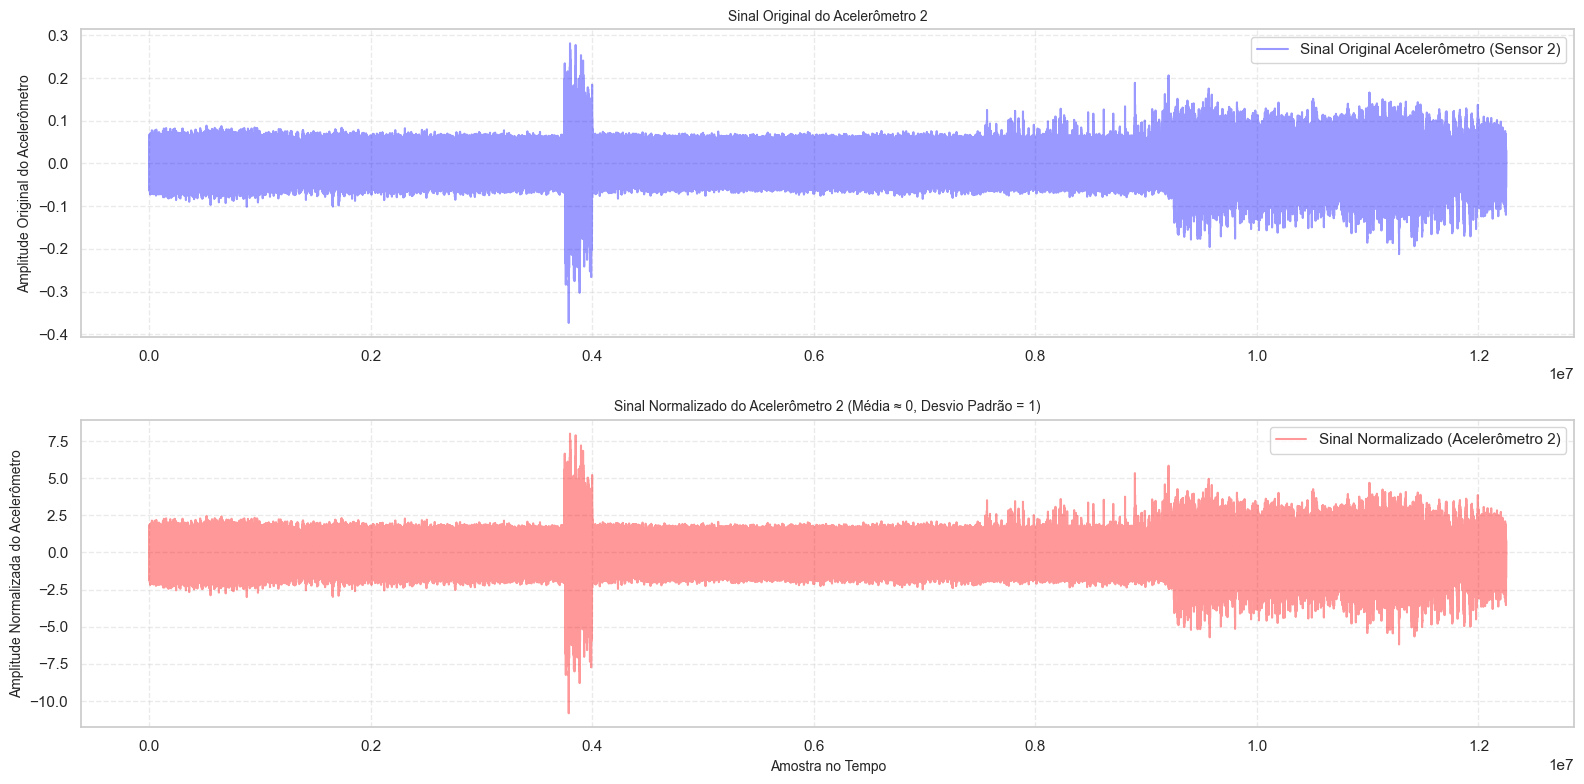

PLOTAGEM COM TEMPO INICIAL LONGO


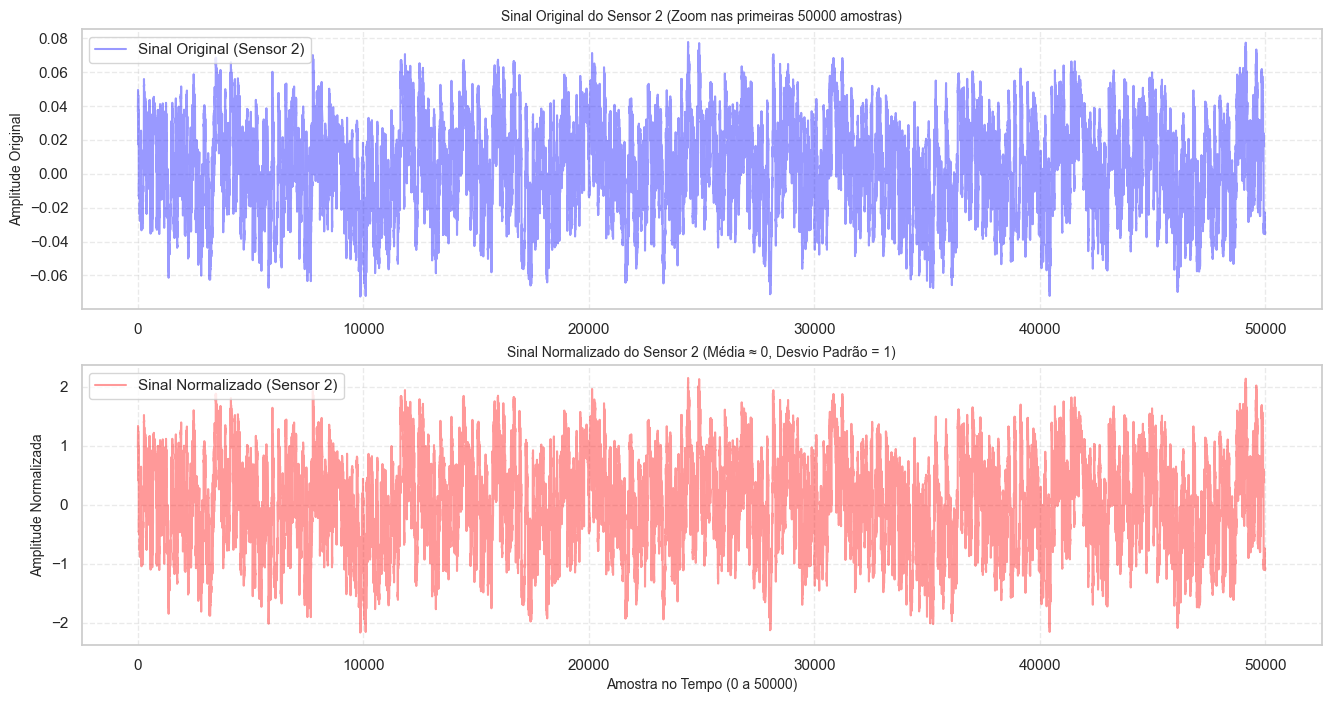

In [ ]:
sensor_a_visualizar = 2 # acelerômetro normal sinal radial condição normal.
num_amostras_plot = 50000
# Acessa os dados originais (X deve ser um array NumPy)
raw_normal_signal = X[:, sensor_a_visualizar]
# Acessa os dados já escalados
scaled_normal_signal = X_scaled[:, sensor_a_visualizar]
# --- Gráfico 1: Comparação do Sinal no Tempo ---
plt.figure(figsize=(16, 8))

# plotagem com tempo inicial curto:
print("PLOTAGEM COM TEMPO INICIAL CURTO")

# Gráfico do sinal original
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(raw_normal_signal, label=f'Sinal Original Acelerômetro (Sensor {sensor_a_visualizar})', color='blue', alpha=0.4)
plt.title(f'Sinal Original do Acelerômetro {sensor_a_visualizar}', fontsize=10)
plt.ylabel('Amplitude Original do Acelerômetro', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Gráfico do sinal normalizado
plt.subplot(2, 1, 2)
plt.plot(scaled_normal_signal, label=f'Sinal Normalizado (Acelerômetro {sensor_a_visualizar})', color='red', alpha=0.4)
plt.title(f'Sinal Normalizado do Acelerômetro {sensor_a_visualizar} (Média ≈ 0, Desvio Padrão = 1)', fontsize=10)
plt.xlabel('Amostra no Tempo', fontsize=10)
plt.ylabel('Amplitude Normalizada do Acelerômetro', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


# plotagem com tempo inicial LONGO:
print("PLOTAGEM COM TEMPO INICIAL LONGO")

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
# Aplica o fatiamento com o novo número de amostras
plt.plot(raw_normal_signal[:num_amostras_plot], label=f'Sinal Original (Sensor {sensor_a_visualizar})', color='blue', alpha=0.4)
plt.title(f'Sinal Original do Sensor {sensor_a_visualizar} (Zoom nas primeiras {num_amostras_plot} amostras)', fontsize=10)
plt.ylabel('Amplitude Original', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Gráfico do sinal normalizado
plt.subplot(2, 1, 2)
# Aplica o fatiamento com o novo número de amostras
plt.plot(scaled_normal_signal[:num_amostras_plot], label=f'Sinal Normalizado (Sensor {sensor_a_visualizar})', color='red', alpha=0.4)
plt.title(f'Sinal Normalizado do Sensor {sensor_a_visualizar} (Média ≈ 0, Desvio Padrão = 1)', fontsize=10)
plt.xlabel(f'Amostra no Tempo (0 a {num_amostras_plot})', fontsize=10)
plt.ylabel('Amplitude Normalizada', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

- Estrutura Temporal: Séries temporais longas (1,2 milhão de amostras no total), com o zoom destacando o início (50.000 amostras).
- Forma da Onda:
    - No sinal completo: Oscilações estáveis, um pico anômalo e aumento de variabilidade no final. Anomalia: Por volta da amostra 400.000, há um pico abrupto, atingindo 0,3 (máximo) e -0,3 (mínimo). Esse pico sugere um evento súbito, como um impacto ou falha mecânica.
    - No zoom inicial: Oscilações rápidas de alta frequência, sem tendências ou periodicidade claras.
- Amplitude:
    - Original: -0,4 a 0,3 (completo); -0,06 a 0,08 (zoom).
    - Normalizado: -10 a 7,5 (completo); -2 a 2 (zoom).

- Características: O sinal reflete vibrações de um sistema mecânico, com estabilidade inicial, uma perturbação transitória e mudanças posteriores. A normalização destaca essas variações para análise.

PLOTAGEM COM TEMPO INICIAL LONGO


<Figure size 1600x800 with 0 Axes>

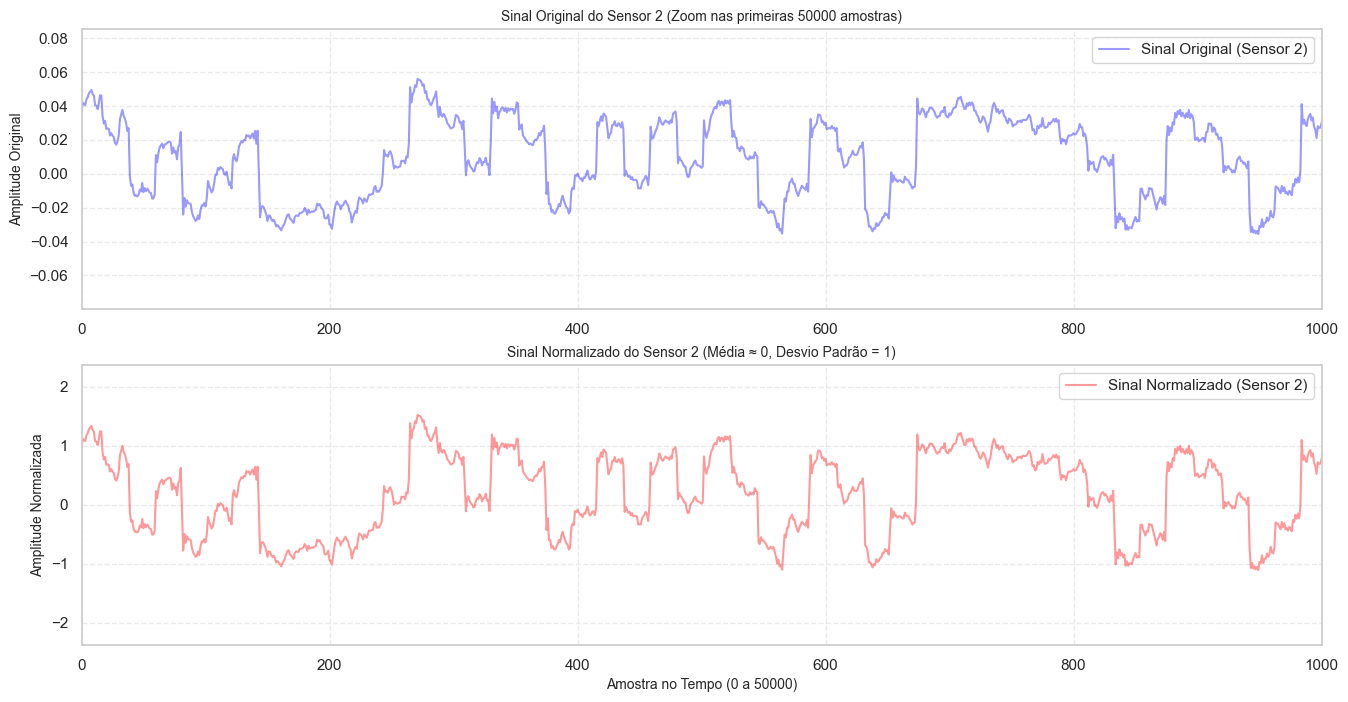

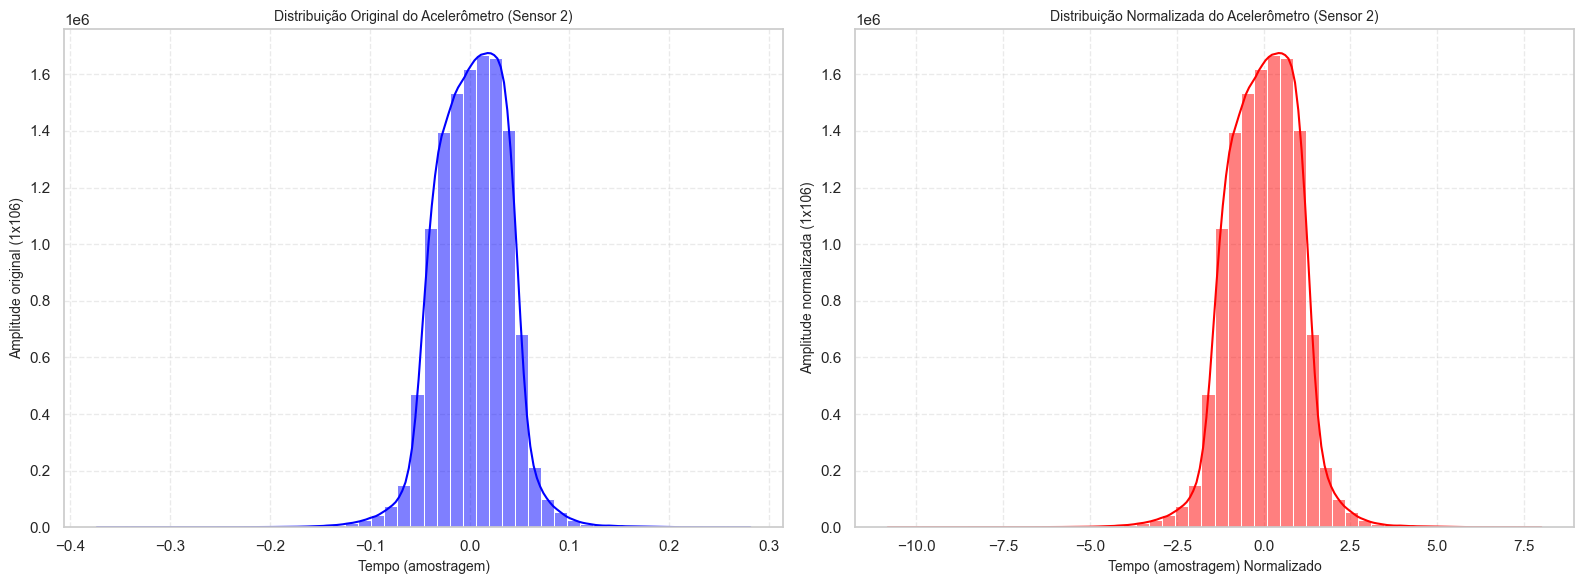


Visualização concluída.


In [11]:
sensor_a_visualizar = 2 # acelerômetro overhang sinal radial condição normal.
num_amostras_plot = 50000
# Acessa os dados originais (X deve ser um array NumPy)
raw_normal_signal = X[:, sensor_a_visualizar]
# Acessa os dados já escalados
scaled_normal_signal = X_scaled[:, sensor_a_visualizar]
# --- Gráfico 1: Comparação do Sinal no Tempo ---
plt.figure(figsize=(16, 8))

print("PLOTAGEM COM TEMPO INICIAL LONGO")

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
# Aplica o fatiamento com o novo número de amostras
plt.plot(raw_normal_signal[:num_amostras_plot], label=f'Sinal Original (Sensor {sensor_a_visualizar})', color='blue', alpha=0.4)
plt.title(f'Sinal Original do Sensor {sensor_a_visualizar} (Zoom nas primeiras {num_amostras_plot} amostras)', fontsize=10)
plt.ylabel('Amplitude Original', fontsize=10)
plt.legend()
plt.xlim(0, 1000)
plt.grid(True, linestyle='--', alpha=0.4)

# Gráfico do sinal normalizado
plt.subplot(2, 1, 2)
# Aplica o fatiamento com o novo número de amostras
plt.plot(scaled_normal_signal[:num_amostras_plot], label=f'Sinal Normalizado (Sensor {sensor_a_visualizar})', color='red', alpha=0.4)
plt.title(f'Sinal Normalizado do Sensor {sensor_a_visualizar} (Média ≈ 0, Desvio Padrão = 1)', fontsize=10)
plt.xlabel(f'Amostra no Tempo (0 a {num_amostras_plot})', fontsize=10)
plt.ylabel('Amplitude Normalizada', fontsize=10)
plt.legend()
plt.xlim(0, 1000)
plt.grid(True, linestyle='--', alpha=0.4)

# --- Gráfico 2: Comparação da Distribuição dos Dados (Histograma) ---
plt.figure(figsize=(16, 6))

# Histograma do sinal original
plt.subplot(1, 2, 1)
sns.histplot(raw_normal_signal, kde=True, color='blue', bins=50)
plt.title(f'Distribuição Original do Acelerômetro (Sensor {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Tempo (amostragem)', fontsize=10)
plt.ylabel('Amplitude original (1x106)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)

# Histograma do sinal normalizado
plt.subplot(1, 2, 2)
sns.histplot(X_scaled[:, sensor_a_visualizar], kde=True, color='red', bins=50)
plt.title(f'Distribuição Normalizada do Acelerômetro (Sensor {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Tempo (amostragem) Normalizado', fontsize=10)
plt.ylabel('Amplitude normalizada (1x106)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

print("\nVisualização concluída.")

### Métricas Estatísticas:

#### Tecnicas no domınio da frequencia: Analise espectral

##### Transformada Rápida de Fourier

In [ ]:
%pip install -U scipy

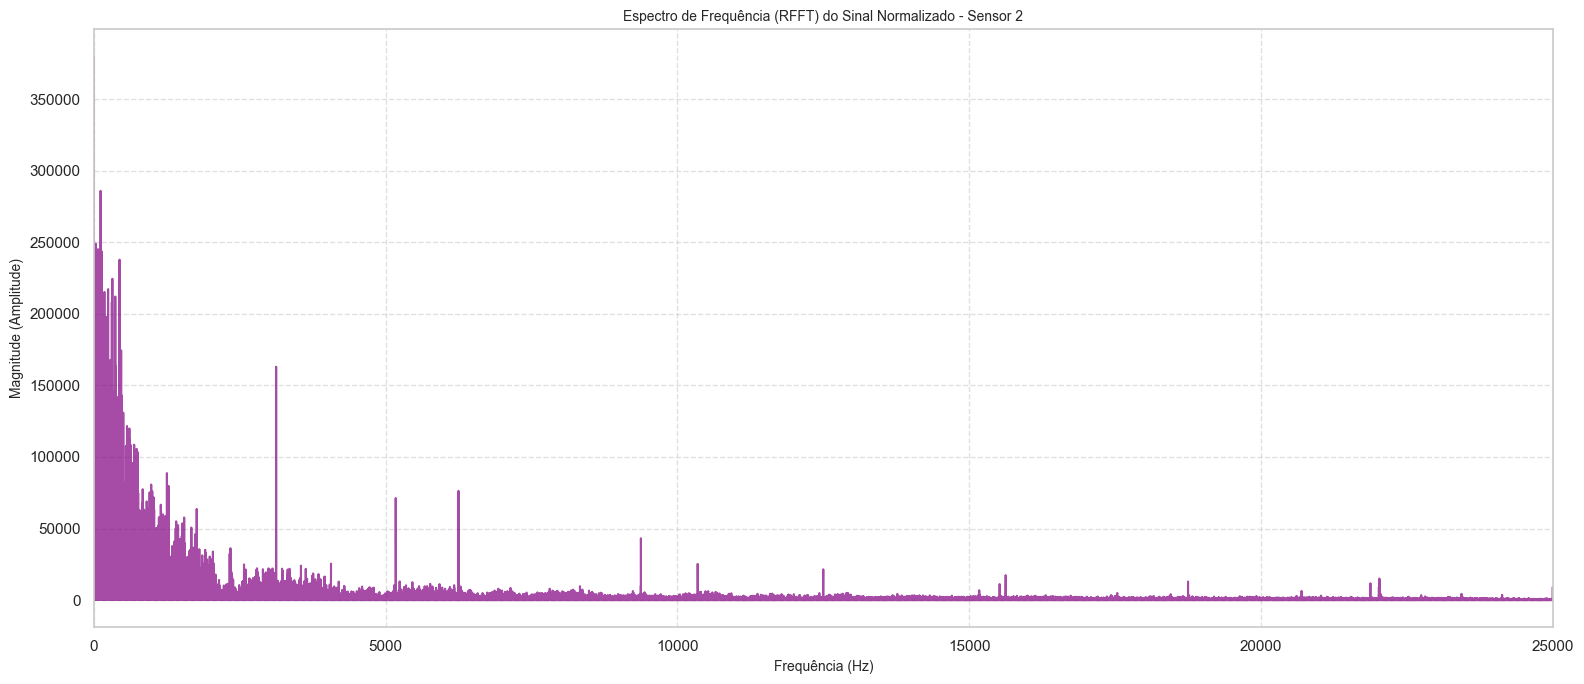

In [13]:
from scipy.fft import rfft, rfftfreq
SAMPLE_RATE = 50000     # em Hz


# sensor_a_visualizar = 2  # Or any other appropriate value
# X_scaled = ...  # Your scaled data

# Ensure X_scaled está definido e sensor_a_visualizar e verifica se tem índice válido
if 'X_scaled' not in locals() and 'X_scaled' not in globals():
	raise NameError("X_scaled is not defined. Please run the cell where X_scaled is calculated.")

if 'sensor_a_visualizar' not in locals() and 'sensor_a_visualizar' not in globals():
	raise NameError("sensor_a_visualizar is not defined. Please run the cell where sensor_a_visualizar is defined.")

# Extrai o sinal do sensor escolhido para visualização
scaled_normal_signal = X_scaled[:, sensor_a_visualizar]

# 1. Calcula a Transformada Rápida de Fourier Real (RFFT)
fft_values = rfft(scaled_normal_signal)

# 2. Calcula as frequências correspondentes aos valores da FFT where N is the number of points in the time signal
N = len(scaled_normal_signal)
frequencies = rfftfreq(N, 1 / SAMPLE_RATE) 

# --- Plota a Magnitude da RFFT ---
plt.figure(figsize=(16, 7))
plt.plot(frequencies, np.abs(fft_values), color='purple', alpha=0.7)
plt.title(f'Espectro de Frequência (RFFT) do Sinal Normalizado - Sensor {sensor_a_visualizar}', fontsize=10)
plt.xlabel('Frequência (Hz)', fontsize=10)
plt.ylabel('Magnitude (Amplitude)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, SAMPLE_RATE / 2) # Limita o eixo X à frequência de Nyquist
plt.tight_layout()
plt.show()


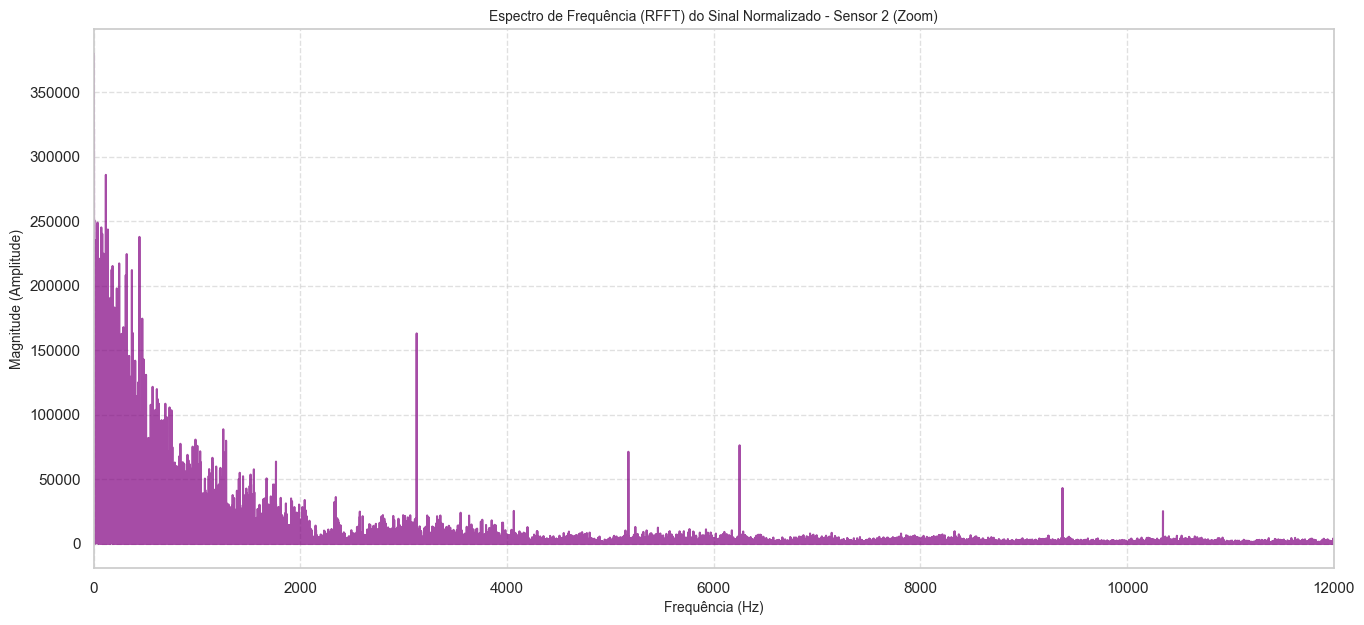

In [14]:
# --- Plotagem da Magnitude da RFFT com Zoom ---
plt.figure(figsize=(16, 7))
plt.plot(frequencies, np.abs(fft_values), color='purple', alpha=0.7)
plt.title(f'Espectro de Frequência (RFFT) do Sinal Normalizado - Sensor {sensor_a_visualizar} (Zoom)', fontsize=10)
plt.xlim(0, 12000)
plt.xlabel('Frequência (Hz)', fontsize=10)
plt.ylabel('Magnitude (Amplitude)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

### Filtro Passa Banda de ordem 3:

In [22]:
# Deve-se definir a banda de ressonância da sua máquina.
# Estes são valores EXEMPLO:
fc_low = 10  # Frequência de corte inferior (Hz) - Exemplo: 2 kHz
fc_high = 3500 # Frequência de corte superior (Hz) - Exemplo: 8 kHz
order = 3      # Ordem do filtro (quanto maior, mais íngreme o corte, mas pode introduzir mais atraso)


# As frequências de corte são normalizadas pela frequência de Nyquist (SAMPLE_RATE / 2).
nyquist = 0.5 * SAMPLE_RATE
normal_fc_low = fc_low / nyquist
normal_fc_high = fc_high / nyquist

#### 3. Aplicar o Filtro Butterworth Passa-Banda

In [23]:
from scipy.signal import butter, filtfilt

# 'b' e 'a' são os coeficientes do numerador e denominador do filtro.
b, a = butter(order, [normal_fc_low, normal_fc_high], btype='band', analog=False)

# 'filtfilt' aplica o filtro para frente e para trás, eliminando o atraso de fase.
signal_filtered = filtfilt(b, a, raw_normal_signal)

print(f"Filtro Passa-Banda aplicado: {fc_low}-{fc_high} Hz, Ordem: {order}")



Filtro Passa-Banda aplicado: 10-3500 Hz, Ordem: 3


#### 3.1 - Plotar o Filtro Passa Banda aplicado ao sinal com Zoom:

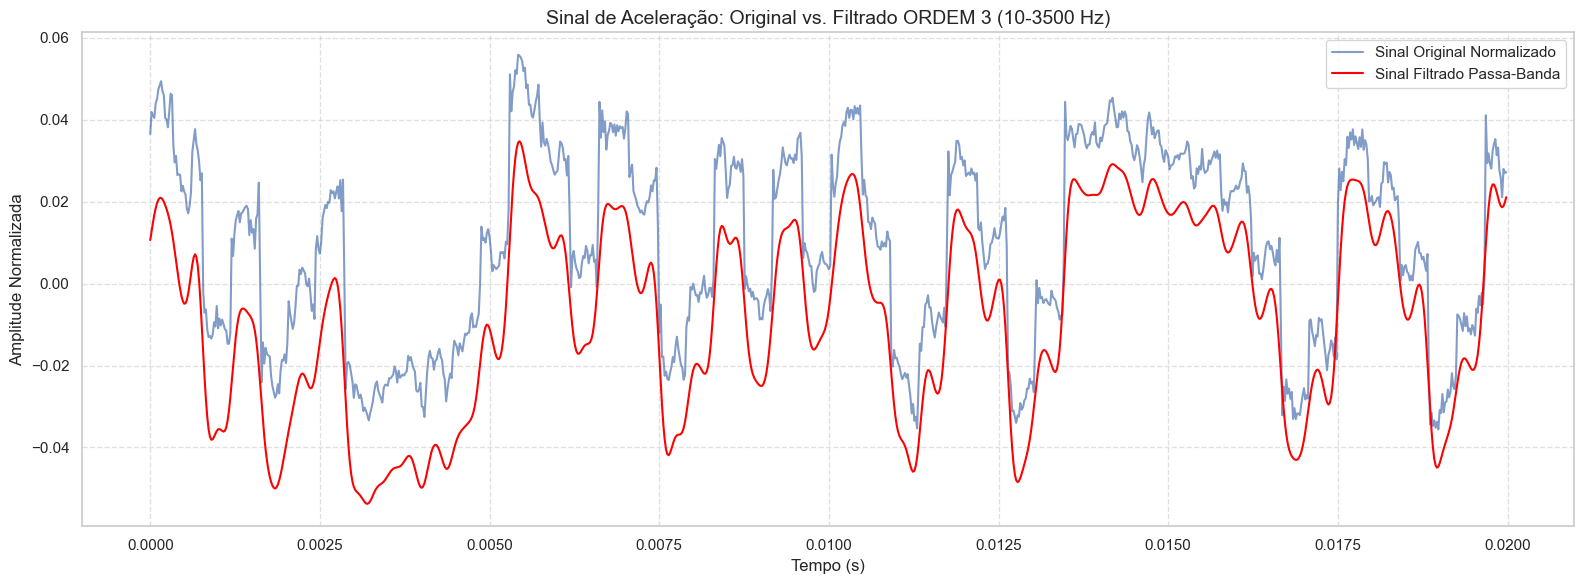

C:\Users\carlo\AppData\Local\Temp\ipykernel_7052\2421866888.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


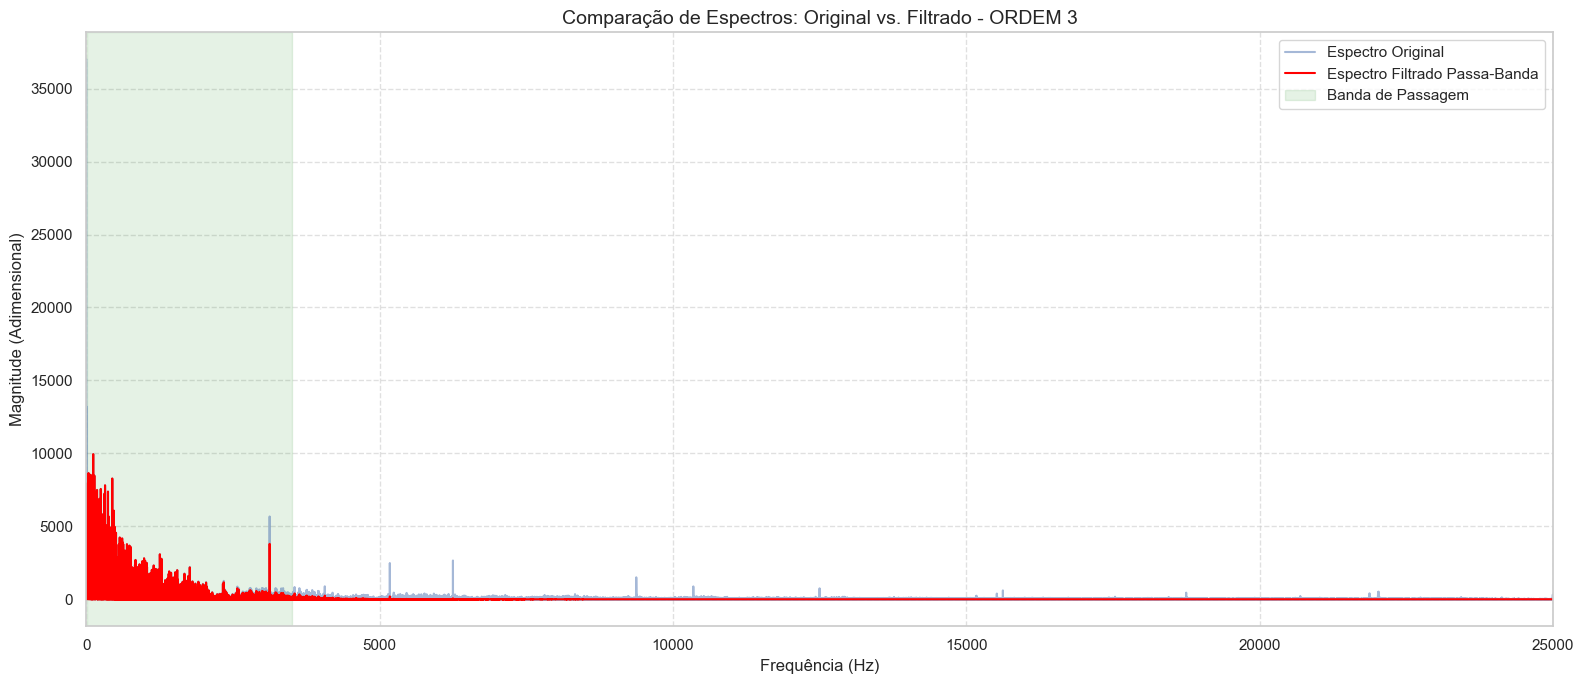

In [25]:
num_amostras_zoom_plot = 1000 # Para melhor visualização no tempo
t_axis = np.arange(num_amostras_zoom_plot) / SAMPLE_RATE

plt.figure(figsize=(16, 6))
plt.plot(t_axis, raw_normal_signal[:num_amostras_zoom_plot], label='Sinal Original Normalizado', alpha=0.7)
plt.plot(t_axis, signal_filtered[:num_amostras_zoom_plot], label='Sinal Filtrado Passa-Banda', color='red', linewidth=1.5)
plt.title(f'Sinal de Aceleração: Original vs. Filtrado ORDEM 3 ({fc_low}-{fc_high} Hz)', fontsize=14)
plt.xlabel('Tempo (s)', fontsize=12)
plt.ylabel('Amplitude Normalizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 6. Plotar os Espectros (Original vs. Filtrado) para Análise em Frequência ---
N_fft = len(raw_normal_signal)
xf_original, yf_original = rfftfreq(N_fft, 1/SAMPLE_RATE), np.abs(rfft(raw_normal_signal))
xf_filtered, yf_filtered = rfftfreq(N_fft, 1/SAMPLE_RATE), np.abs(rfft(signal_filtered))

plt.figure(figsize=(16, 7))
plt.plot(xf_original, yf_original, label='Espectro Original', alpha=0.5)
plt.plot(xf_filtered, yf_filtered, label='Espectro Filtrado Passa-Banda', color='red', linewidth=1.5)
plt.axvspan(fc_low, fc_high, color='green', alpha=0.1, label='Banda de Passagem') # Destaca a banda
plt.title('Comparação de Espectros: Original vs. Filtrado - ORDEM 3', fontsize=14)
plt.xlabel('Frequência (Hz)', fontsize=12)
plt.ylabel('Magnitude (Adimensional)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, nyquist) # Mostra todo o espectro até Nyquist
# Opcional: plt.xlim(0, 10000) # Para um zoom visual onde a banda de passagem estaria
plt.tight_layout()
plt.show()

- "Contagem" significa a frequência ou o número de vezes que um determinado valor de amplitude ocorreu no seu conjunto de dados.
- A linha azul contínua (chamada de KDE - Kernel Density Estimate) é uma versão suavizada do histograma. O pico dessa linha mostra qual é o valor de amplitude mais comum em todo o conjunto de dados.

### Filtro Passa Banda de ordem 4:


--- Verificação do Sinal Original ---
Número de NaN's em raw_normal_signal: 0
Tamanho total de raw_normal_signal: 12249951

--- Verificação dos Parâmetros do Filtro ---
Frequência de Nyquist (Hz): 25000.00
Frequência de Corte Inferior Normalizada: 0.0004
Frequência de Corte Superior Normalizada: 0.1400
Filtro Passa-Banda aplicado: 10-3500 Hz, Ordem: 4

--- Verificação do Sinal Filtrado ---
Número de NaN's em signal_filtered após filtfilt: 0
Tamanho total de signal_filtered: 12249951


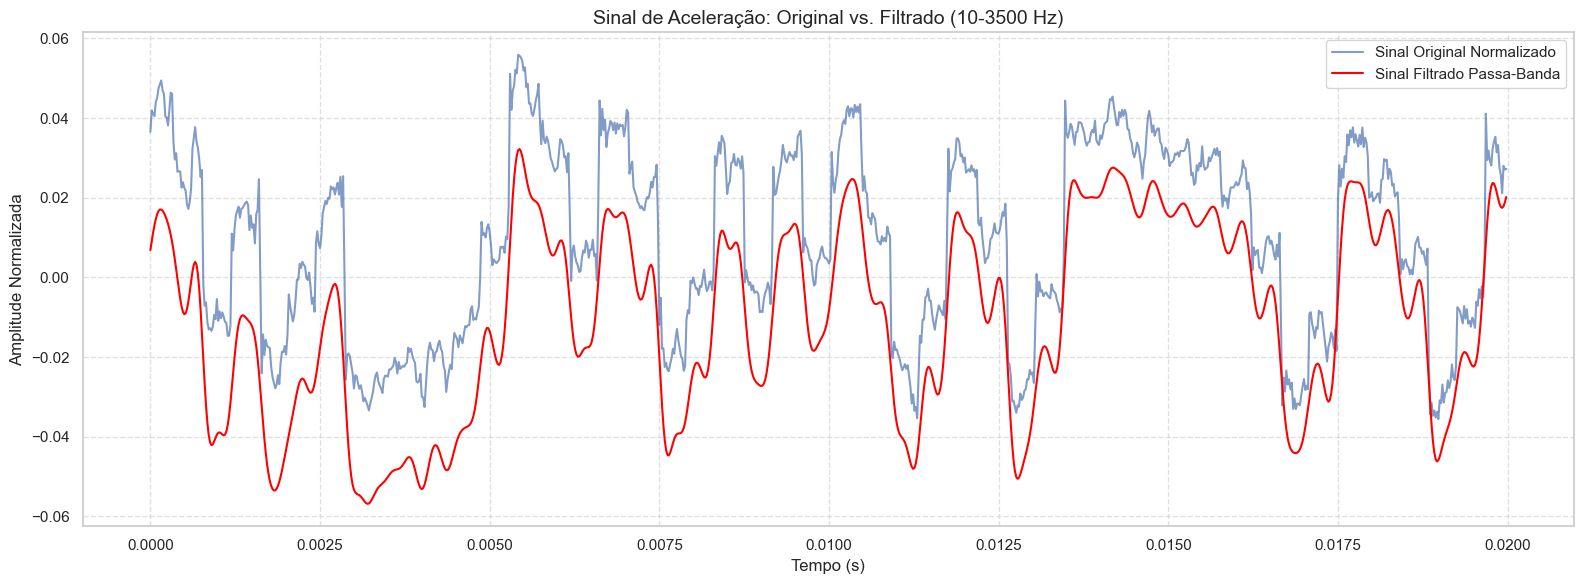

C:\Users\carlo\AppData\Local\Temp\ipykernel_7052\1684853516.py:147: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


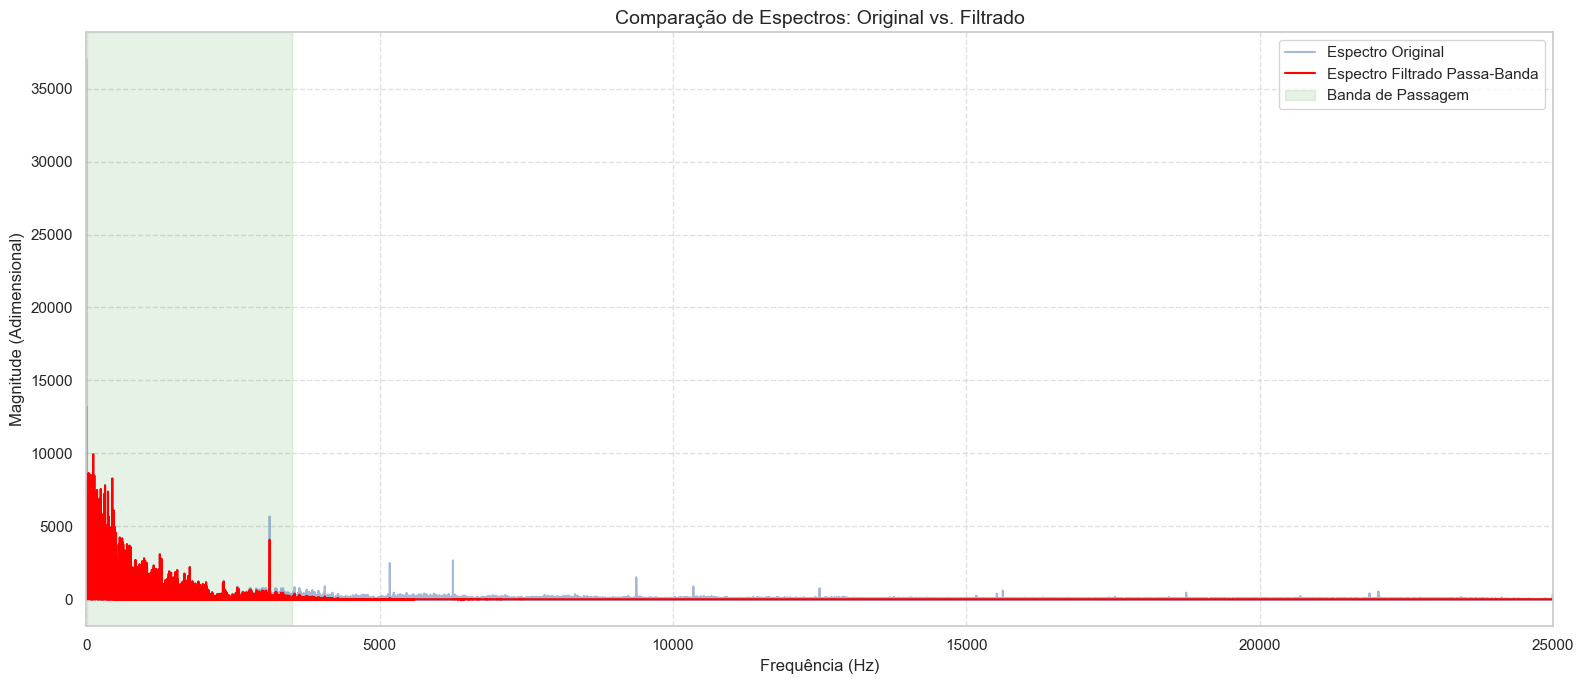

In [27]:
from scipy.signal import butter, filtfilt
from scipy.fft import rfft, rfftfreq
from scipy.stats import skew # Para o histograma e skewness, se for usar mais tarde

# --- VERIFICAÇÃO DE NaN's NO SINAL ORIGINAL (Adicionado aqui) ---
# É crucial que 'raw_normal_signal' e 'SAMPLE_RATE' estejam definidos antes deste ponto.
print("\n--- Verificação do Sinal Original ---")
if 'raw_normal_signal' in locals() or 'raw_normal_signal' in globals():
    if isinstance(raw_normal_signal, np.ndarray):
        num_nans_raw = np.sum(np.isnan(raw_normal_signal))
        print(f"Número de NaN's em raw_normal_signal: {num_nans_raw}")
        print(f"Tamanho total de raw_normal_signal: {raw_normal_signal.size}")
        if raw_normal_signal.size > 0 and num_nans_raw == raw_normal_signal.size:
            print("AVISO: raw_normal_signal está TODO preenchido com NaN's. O filtro não funcionará.")
        elif raw_normal_signal.size == 0:
            print("AVISO: raw_normal_signal é um array vazio. O filtro não funcionará.")
        elif num_nans_raw > 0:
            print("ATENÇÃO: raw_normal_signal contém NaN's. Isso pode afetar o filtro.")
    else:
        print("ERRO: raw_normal_signal não é um array NumPy. Verifique sua definição.")
else:
    print("ERRO: raw_normal_signal não está definido. Por favor, defina-o antes de prosseguir.")

if 'SAMPLE_RATE' not in locals() and 'SAMPLE_RATE' not in globals():
    print("ERRO: SAMPLE_RATE não está definida. Por favor, defina-a (ex: SAMPLE_RATE = 25000).")
    # Para o propósito de continuar o script para debug, vamos definir um valor padrão.
    # Em um código de produção, você provavelmente pararia aqui ou pediria para o usuário definir.
    SAMPLE_RATE = 1.0 # Valor padrão para evitar NameError nas próximas linhas.
    print(f"Usando SAMPLE_RATE = {SAMPLE_RATE} como padrão para continuar.")
elif SAMPLE_RATE <= 0:
    print("AVISO CRÍTICO: SAMPLE_RATE é zero ou negativo. Isso causará problemas na filtragem.")
    # Considerar definir um valor válido ou parar o script.


# Deve-se definir a banda de ressonância da sua máquina.
# Estes são valores EXEMPLO:
fc_low = 10  # Frequência de corte inferior (Hz) - Exemplo: 2 kHz
fc_high = 3500 # Frequência de corte superior (Hz) - Exemplo: 8 kHz
order = 4      # Ordem do filtro (quanto maior, mais íngreme o corte, mas pode introduzir mais atraso)


# As frequências de corte são normalizadas pela frequência de Nyquist (SAMPLE_RATE / 2).
nyquist = 0.5 * SAMPLE_RATE
normal_fc_low = fc_low / nyquist
normal_fc_high = fc_high / nyquist

# --- Verificação dos parâmetros de frequência normalizada (adicionado) ---
print("\n--- Verificação dos Parâmetros do Filtro ---")
print(f"Frequência de Nyquist (Hz): {nyquist:.2f}")
print(f"Frequência de Corte Inferior Normalizada: {normal_fc_low:.4f}")
print(f"Frequência de Corte Superior Normalizada: {normal_fc_high:.4f}")

if normal_fc_low >= 1.0 or normal_fc_high >= 1.0:
    print("AVISO CRÍTICO: Pelo menos uma frequência de corte normalizada é >= 1.0. Isso pode causar o problema de NaN's.")
if normal_fc_low >= normal_fc_high:
    print("AVISO: fc_low é maior ou igual a fc_high. O filtro pode não funcionar como esperado.")


# Importa as funções do scipy.signal (já estavam no seu código, mantive aqui por clareza)
# from scipy.signal import butter, filtfilt # Já importadas acima

# 'b' e 'a' são os coeficientes do numerador e denominador do filtro.
# Adicionado tratamento de erro para a criação do filtro
try:
    b, a = butter(order, [normal_fc_low, normal_fc_high], btype='band', analog=False)
except ValueError as e:
    print(f"ERRO ao criar o filtro butterworth: {e}")
    print("Verifique os parâmetros 'order' e as frequências de corte normalizadas.")
    # Se o filtro não puder ser criado, não faz sentido continuar a filtragem.
    # Aqui você pode sair do script ou definir signal_filtered como um array de NaNs
    signal_filtered = np.full_like(raw_normal_signal, np.nan) # Preenche com NaNs para evitar mais erros
else:
    # 'filtfilt' aplica o filtro para frente e para trás, eliminando o atraso de fase.
    signal_filtered = filtfilt(b, a, raw_normal_signal)

print(f"Filtro Passa-Banda aplicado: {fc_low}-{fc_high} Hz, Ordem: {order}")

# --- Verificação de NaN's NO SINAL FILTRADO (Adicionado aqui) ---
print("\n--- Verificação do Sinal Filtrado ---")
num_nans_filtered = np.sum(np.isnan(signal_filtered))
print(f"Número de NaN's em signal_filtered após filtfilt: {num_nans_filtered}")
print(f"Tamanho total de signal_filtered: {signal_filtered.size}")
if signal_filtered.size > 0 and num_nans_filtered == signal_filtered.size:
    print("AVISO CRÍTICO: signal_filtered está TODO preenchido com NaN's após a filtragem.")
elif num_nans_filtered > 0:
    print("ATENÇÃO: signal_filtered contém alguns NaN's após a filtragem.")


num_amostras_zoom_plot = 1000 # Para melhor visualização no tempo
# Garante que t_axis não seja criado com divisao por zero se SAMPLE_RATE for 0
if SAMPLE_RATE > 0:
    t_axis = np.arange(num_amostras_zoom_plot) / SAMPLE_RATE
else:
    t_axis = np.arange(num_amostras_zoom_plot) # Ou um array de zeros, ou pular o plot de tempo

plt.figure(figsize=(16, 6))
# Adicionado verificação para plots para evitar erro se o sinal for todo NaN
if not np.all(np.isnan(raw_normal_signal)) and raw_normal_signal.size > 0:
    plt.plot(t_axis, raw_normal_signal[:num_amostras_zoom_plot], label='Sinal Original Normalizado', alpha=0.7)
else:
    print("Não é possível plotar o sinal original no tempo: todo NaN ou vazio.")

if not np.all(np.isnan(signal_filtered)) and signal_filtered.size > 0:
    plt.plot(t_axis, signal_filtered[:num_amostras_zoom_plot], label='Sinal Filtrado Passa-Banda', color='red', linewidth=1.5)
else:
    print("Não é possível plotar o sinal filtrado no tempo: todo NaN ou vazio.")

plt.title(f'Sinal de Aceleração: Original vs. Filtrado ({fc_low}-{fc_high} Hz)', fontsize=14)
plt.xlabel('Tempo (s)', fontsize=12)
plt.ylabel('Amplitude Normalizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 6. Plotar os Espectros (Original vs. Filtrado) para Análise em Frequência ---
N_fft = len(raw_normal_signal) if raw_normal_signal.size > 0 else 0 # Evita erro se sinal for vazio

plt.figure(figsize=(16, 7))

# Verificações antes de plotar espectros
if N_fft > 0 and not np.all(np.isnan(raw_normal_signal)):
    xf_original, yf_original = rfftfreq(N_fft, 1/SAMPLE_RATE), np.abs(rfft(raw_normal_signal))
    plt.plot(xf_original, yf_original, label='Espectro Original', alpha=0.5)
else:
    print("Não é possível plotar o espectro original: sinal todo NaN, vazio ou SAMPLE_RATE inválida.")

if N_fft > 0 and not np.all(np.isnan(signal_filtered)):
    xf_filtered, yf_filtered = rfftfreq(N_fft, 1/SAMPLE_RATE), np.abs(rfft(signal_filtered))
    plt.plot(xf_filtered, yf_filtered, label='Espectro Filtrado Passa-Banda', color='red', linewidth=1.5)
else:
    print("Não é possível plotar o espectro filtrado: sinal todo NaN, vazio ou SAMPLE_RATE inválida.")

plt.axvspan(fc_low, fc_high, color='green', alpha=0.1, label='Banda de Passagem') # Destaca a banda
plt.title('Comparação de Espectros: Original vs. Filtrado', fontsize=14)
plt.xlabel('Frequência (Hz)', fontsize=12)
plt.ylabel('Magnitude (Adimensional)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
# Ajusta o xlim apenas se nyquist for um número válido e positivo
if np.isfinite(nyquist) and nyquist > 0:
    plt.xlim(0, nyquist) # Mostra todo o espectro até Nyquist
else:
    print("Não é possível definir xlim para o espectro: Nyquist inválida.")

# Opcional: plt.xlim(0, 10000) # Para um zoom visual onde a banda de passagem estaria
plt.tight_layout()
plt.show()


--- Verificação do Sinal Original ---
Número de NaN's em raw_normal_signal: 0
Tamanho total de raw_normal_signal: 12249951

--- Verificação dos Parâmetros do Filtro ---
Frequência de Nyquist (Hz): 25000.00
Frequência de Corte Inferior Normalizada: 0.0004
Frequência de Corte Superior Normalizada: 0.1400
Filtro Passa-Banda aplicado: 10-3500 Hz, Ordem: 5

--- Verificação do Sinal Filtrado ---
Número de NaN's em signal_filtered após filtfilt: 12249951
Tamanho total de signal_filtered: 12249951
AVISO CRÍTICO: signal_filtered está TODO preenchido com NaN's após a filtragem.
Não é possível plotar o sinal filtrado no tempo: todo NaN ou vazio.


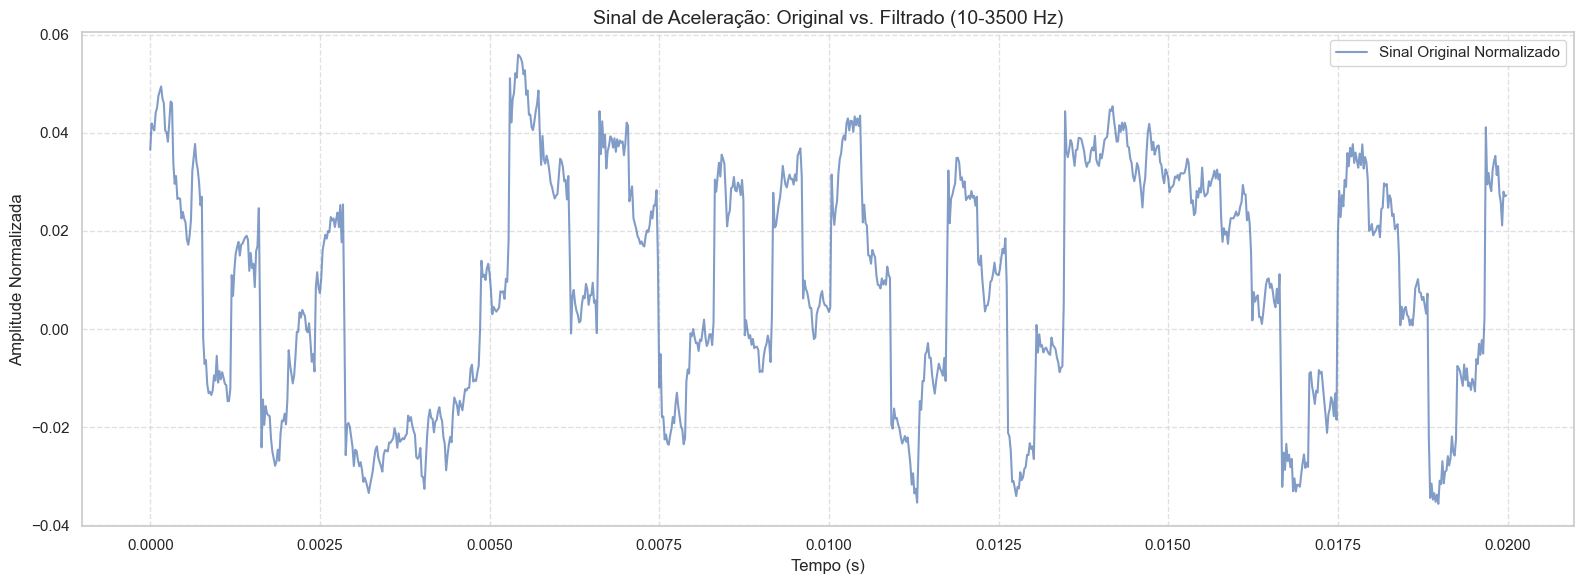

Não é possível plotar o espectro filtrado: sinal todo NaN, vazio ou SAMPLE_RATE inválida.


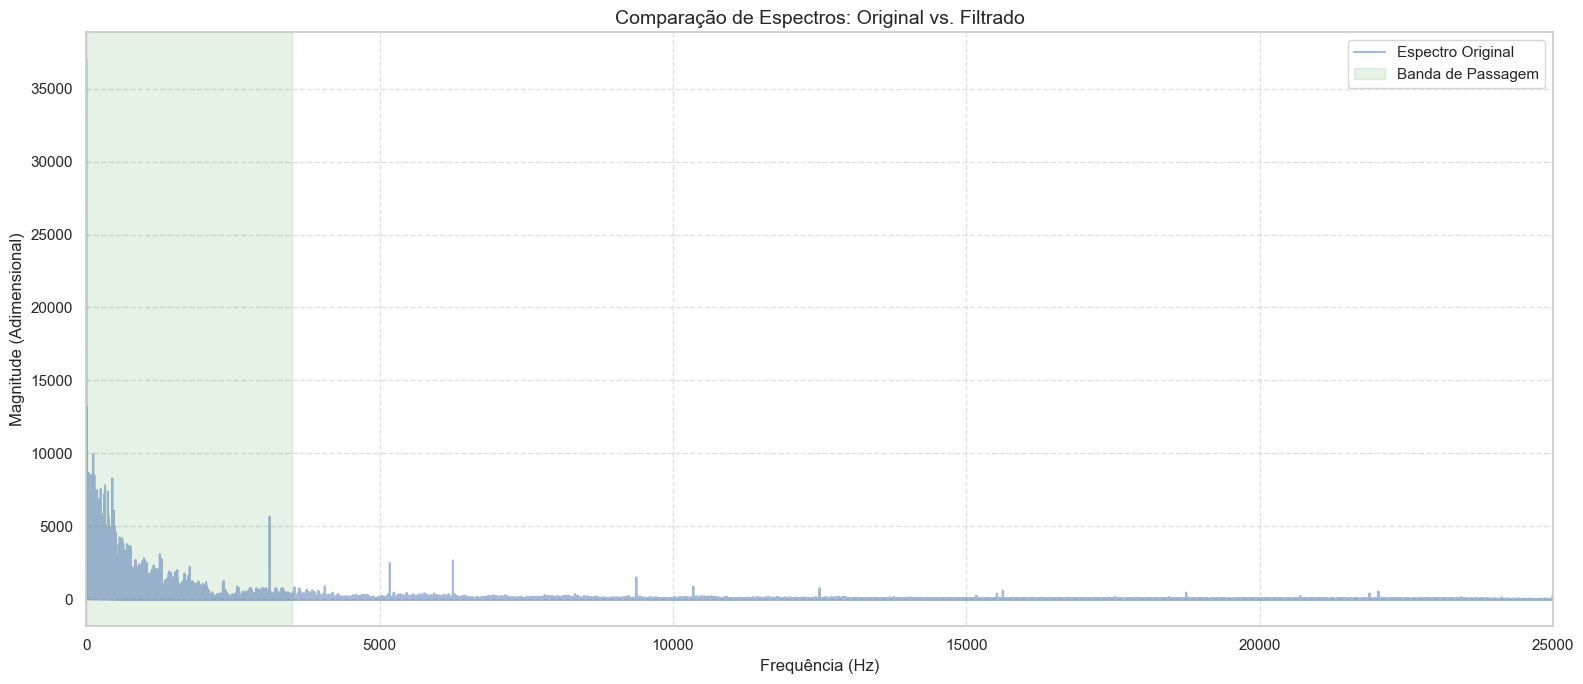

In [28]:
from scipy.signal import butter, filtfilt
from scipy.fft import rfft, rfftfreq
from scipy.stats import skew # Para o histograma e skewness, se for usar mais tarde

# --- VERIFICAÇÃO DE NaN's NO SINAL ORIGINAL (Adicionado aqui) ---
# É crucial que 'raw_normal_signal' e 'SAMPLE_RATE' estejam definidos antes deste ponto.
print("\n--- Verificação do Sinal Original ---")
if 'raw_normal_signal' in locals() or 'raw_normal_signal' in globals():
    if isinstance(raw_normal_signal, np.ndarray):
        num_nans_raw = np.sum(np.isnan(raw_normal_signal))
        print(f"Número de NaN's em raw_normal_signal: {num_nans_raw}")
        print(f"Tamanho total de raw_normal_signal: {raw_normal_signal.size}")
        if raw_normal_signal.size > 0 and num_nans_raw == raw_normal_signal.size:
            print("AVISO: raw_normal_signal está TODO preenchido com NaN's. O filtro não funcionará.")
        elif raw_normal_signal.size == 0:
            print("AVISO: raw_normal_signal é um array vazio. O filtro não funcionará.")
        elif num_nans_raw > 0:
            print("ATENÇÃO: raw_normal_signal contém NaN's. Isso pode afetar o filtro.")
    else:
        print("ERRO: raw_normal_signal não é um array NumPy. Verifique sua definição.")
else:
    print("ERRO: raw_normal_signal não está definido. Por favor, defina-o antes de prosseguir.")

if 'SAMPLE_RATE' not in locals() and 'SAMPLE_RATE' not in globals():
    print("ERRO: SAMPLE_RATE não está definida. Por favor, defina-a (ex: SAMPLE_RATE = 25000).")
    # Para o propósito de continuar o script para debug, vamos definir um valor padrão.
    # Em um código de produção, você provavelmente pararia aqui ou pediria para o usuário definir.
    SAMPLE_RATE = 1.0 # Valor padrão para evitar NameError nas próximas linhas.
    print(f"Usando SAMPLE_RATE = {SAMPLE_RATE} como padrão para continuar.")
elif SAMPLE_RATE <= 0:
    print("AVISO CRÍTICO: SAMPLE_RATE é zero ou negativo. Isso causará problemas na filtragem.")
    # Considerar definir um valor válido ou parar o script.


# Deve-se definir a banda de ressonância da sua máquina.
# Estes são valores EXEMPLO:
fc_low = 10  # Frequência de corte inferior (Hz) - Exemplo: 2 kHz
fc_high = 3500 # Frequência de corte superior (Hz) - Exemplo: 8 kHz
order = 5      # Ordem do filtro (quanto maior, mais íngreme o corte, mas pode introduzir mais atraso)


# As frequências de corte são normalizadas pela frequência de Nyquist (SAMPLE_RATE / 2).
nyquist = 0.5 * SAMPLE_RATE
normal_fc_low = fc_low / nyquist
normal_fc_high = fc_high / nyquist

# --- Verificação dos parâmetros de frequência normalizada (adicionado) ---
print("\n--- Verificação dos Parâmetros do Filtro ---")
print(f"Frequência de Nyquist (Hz): {nyquist:.2f}")
print(f"Frequência de Corte Inferior Normalizada: {normal_fc_low:.4f}")
print(f"Frequência de Corte Superior Normalizada: {normal_fc_high:.4f}")

if normal_fc_low >= 1.0 or normal_fc_high >= 1.0:
    print("AVISO CRÍTICO: Pelo menos uma frequência de corte normalizada é >= 1.0. Isso pode causar o problema de NaN's.")
if normal_fc_low >= normal_fc_high:
    print("AVISO: fc_low é maior ou igual a fc_high. O filtro pode não funcionar como esperado.")


# Importa as funções do scipy.signal (já estavam no seu código, mantive aqui por clareza)
# from scipy.signal import butter, filtfilt # Já importadas acima

# 'b' e 'a' são os coeficientes do numerador e denominador do filtro.
# Adicionado tratamento de erro para a criação do filtro
try:
    b, a = butter(order, [normal_fc_low, normal_fc_high], btype='band', analog=False)
except ValueError as e:
    print(f"ERRO ao criar o filtro butterworth: {e}")
    print("Verifique os parâmetros 'order' e as frequências de corte normalizadas.")
    # Se o filtro não puder ser criado, não faz sentido continuar a filtragem.
    # Aqui você pode sair do script ou definir signal_filtered como um array de NaNs
    signal_filtered = np.full_like(raw_normal_signal, np.nan) # Preenche com NaNs para evitar mais erros
else:
    # 'filtfilt' aplica o filtro para frente e para trás, eliminando o atraso de fase.
    signal_filtered = filtfilt(b, a, raw_normal_signal)

print(f"Filtro Passa-Banda aplicado: {fc_low}-{fc_high} Hz, Ordem: {order}")

# --- Verificação de NaN's NO SINAL FILTRADO (Adicionado aqui) ---
print("\n--- Verificação do Sinal Filtrado ---")
num_nans_filtered = np.sum(np.isnan(signal_filtered))
print(f"Número de NaN's em signal_filtered após filtfilt: {num_nans_filtered}")
print(f"Tamanho total de signal_filtered: {signal_filtered.size}")
if signal_filtered.size > 0 and num_nans_filtered == signal_filtered.size:
    print("AVISO CRÍTICO: signal_filtered está TODO preenchido com NaN's após a filtragem.")
elif num_nans_filtered > 0:
    print("ATENÇÃO: signal_filtered contém alguns NaN's após a filtragem.")


num_amostras_zoom_plot = 1000 # Para melhor visualização no tempo
# Garante que t_axis não seja criado com divisao por zero se SAMPLE_RATE for 0
if SAMPLE_RATE > 0:
    t_axis = np.arange(num_amostras_zoom_plot) / SAMPLE_RATE
else:
    t_axis = np.arange(num_amostras_zoom_plot) # Ou um array de zeros, ou pular o plot de tempo

plt.figure(figsize=(16, 6))
# Adicionado verificação para plots para evitar erro se o sinal for todo NaN
if not np.all(np.isnan(raw_normal_signal)) and raw_normal_signal.size > 0:
    plt.plot(t_axis, raw_normal_signal[:num_amostras_zoom_plot], label='Sinal Original Normalizado', alpha=0.7)
else:
    print("Não é possível plotar o sinal original no tempo: todo NaN ou vazio.")

if not np.all(np.isnan(signal_filtered)) and signal_filtered.size > 0:
    plt.plot(t_axis, signal_filtered[:num_amostras_zoom_plot], label='Sinal Filtrado Passa-Banda', color='red', linewidth=1.5)
else:
    print("Não é possível plotar o sinal filtrado no tempo: todo NaN ou vazio.")

plt.title(f'Sinal de Aceleração: Original vs. Filtrado ({fc_low}-{fc_high} Hz)', fontsize=14)
plt.xlabel('Tempo (s)', fontsize=12)
plt.ylabel('Amplitude Normalizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 6. Plotar os Espectros (Original vs. Filtrado) para Análise em Frequência ---
N_fft = len(raw_normal_signal) if raw_normal_signal.size > 0 else 0 # Evita erro se sinal for vazio

plt.figure(figsize=(16, 7))

# Verificações antes de plotar espectros
if N_fft > 0 and not np.all(np.isnan(raw_normal_signal)):
    xf_original, yf_original = rfftfreq(N_fft, 1/SAMPLE_RATE), np.abs(rfft(raw_normal_signal))
    plt.plot(xf_original, yf_original, label='Espectro Original', alpha=0.5)
else:
    print("Não é possível plotar o espectro original: sinal todo NaN, vazio ou SAMPLE_RATE inválida.")

if N_fft > 0 and not np.all(np.isnan(signal_filtered)):
    xf_filtered, yf_filtered = rfftfreq(N_fft, 1/SAMPLE_RATE), np.abs(rfft(signal_filtered))
    plt.plot(xf_filtered, yf_filtered, label='Espectro Filtrado Passa-Banda', color='red', linewidth=1.5)
else:
    print("Não é possível plotar o espectro filtrado: sinal todo NaN, vazio ou SAMPLE_RATE inválida.")

plt.axvspan(fc_low, fc_high, color='green', alpha=0.1, label='Banda de Passagem') # Destaca a banda
plt.title('Comparação de Espectros: Original vs. Filtrado', fontsize=14)
plt.xlabel('Frequência (Hz)', fontsize=12)
plt.ylabel('Magnitude (Adimensional)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
# Ajusta o xlim apenas se nyquist for um número válido e positivo
if np.isfinite(nyquist) and nyquist > 0:
    plt.xlim(0, nyquist) # Mostra todo o espectro até Nyquist
else:
    print("Não é possível definir xlim para o espectro: Nyquist inválida.")

# Opcional: plt.xlim(0, 10000) # Para um zoom visual onde a banda de passagem estaria
plt.tight_layout()
plt.show()

#### Cálculo de velocidade:

In [28]:
# 1. Extrair o sinal Normal (Coluna 2)
COLUNA_NORMAL = 0        #coluna do tacômetro
# X é o array numpy que contém todos os dados dos sensores. Então, o sinal do tacômetro é a coluna 0 de X.
sinal_normal = X[:, COLUNA_NORMAL] 

# 2. Parâmetros de Amostragem (do seu setup)
TAXA_AMOSTRAGEM = 50000 # Hz (50 kHz)

# 3. Calcular a Duração Total do Sinal em Segundos
duracao_sinal_s = len(sinal_normal) / TAXA_AMOSTRAGEM

# 4. Identificar Pulsos do Tacômetro. O tacômetro geralmente tem um sinal digital ou um pulso claro por revolução.
# Escolhemos um limiar que o sinal deve cruzar para ser contado como um pulso.

limiar_pulso = 2.5 # Este é um valor comum para sinais que alternam entre baixo e alto (e.g., 0 e 5V)

# Detectar os pontos onde o sinal cruza o limiar de baixo para cima (flancos de subida)
# np.where retorna os índices onde a condição é verdadeira.
# sinal_tacometro[:-1] compara todos os pontos exceto o último.
# sinal_tacometro[1:] compara todos os pontos exceto o primeiro.
# A condição detecta quando o ponto anterior estava abaixo do limiar e o ponto atual está acima ou igual.
indices_pulsos = np.where((sinal_normal[:-1] < limiar_pulso) & (sinal_normal[1:] >= limiar_pulso))[0]

# 5. Contar o Número de Pulsos
num_pulsos = len(indices_pulsos)

# 6. Calcular RPM
if duracao_sinal_s > 0:
    rpm_calculado = (num_pulsos / duracao_sinal_s) * 60
    print(f"\nVelocidade de Rotação da Máquina: {rpm_calculado:.2f} RPM")
else:
    rpm_calculado = 0
    print("AVISO: Duração do sinal de tacômetro é zero ou inválida. Não foi possível calcular o RPM.")

# Frequência de Rotação em Hz
frequencia_rotacao_hz = rpm_calculado / 60
print(f"Frequência de Rotação (f1): {frequencia_rotacao_hz:.2f} Hz")


Velocidade de Rotação da Máquina: 2156.82 RPM
Frequência de Rotação (f1): 35.95 Hz
